# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

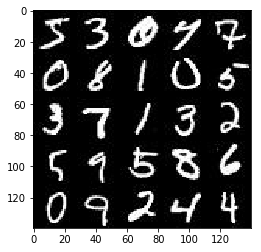

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

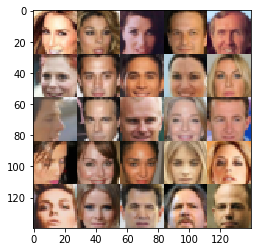

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.6.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="real_inputs")
    z_input = tf.placeholder(tf.float32, (None, z_dim), name="z_input")
    learning_rate = tf.placeholder(tf.float32, name="lr")
    return real_inputs, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1, keep_prob=0.4):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        #Input 28x28x3
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x = tf.maximum(alpha*x, x)
        #Output 14x14x64
        
        x2 = tf.layers.conv2d(x, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        # x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        #Output 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        #Output 4x4x256
        
        logits = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(logits, 1)
        logits = tf.nn.dropout(logits, keep_prob=keep_prob)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1, keep_prob=0.7):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 7*7*512, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        # output 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        # output 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        # output 14x14x128
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha*x4, x4)
        x4 = tf.nn.dropout(x4, keep_prob=keep_prob)
        # output 28x28x64
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, strides=1, padding='same')
        # output 28x28xoutput_dim
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function

    # Generator network
    g_model = generator(input_z, out_channel_dim)

    # Disriminator network
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_logits_real) * 0.9
        )
    )

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)
        )
    )

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)
        )
    )
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
        
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(d_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
         print_every=10, show_every=150):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_inputs, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_inputs, z_input, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={real_inputs: batch_images, z_input: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={real_inputs: batch_images, z_input: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, real_inputs: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, z_input, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/4... Discriminator Loss: 2.6029... Generator Loss: 4.5998
Epoch 1/4... Discriminator Loss: 1.2509... Generator Loss: 2.3217
Epoch 1/4... Discriminator Loss: 1.2085... Generator Loss: 2.0280
Epoch 1/4... Discriminator Loss: 2.9328... Generator Loss: 12.4642
Epoch 1/4... Discriminator Loss: 1.1443... Generator Loss: 5.0586
Epoch 1/4... Discriminator Loss: 1.2610... Generator Loss: 1.9839
Epoch 1/4... Discriminator Loss: 1.2968... Generator Loss: 1.2843
Epoch 1/4... Discriminator Loss: 1.3400... Generator Loss: 0.9905
Epoch 1/4... Discriminator Loss: 1.6745... Generator Loss: 1.3542
Epoch 1/4... Discriminator Loss: 1.1997... Generator Loss: 1.9621
Epoch 1/4... Discriminator Loss: 1.6827... Generator Loss: 1.0914
Epoch 1/4... Discriminator Loss: 1.6311... Generator Loss: 1.8914
Epoch 1/4... Discriminator Loss: 1.6797... Generator Loss: 1.3042
Epoch 1/4... Discriminator Loss: 1.6211... Generator Loss: 0.6065
Epoch 1/4... Discriminator Loss: 1.3458... Generator Loss: 0.8119


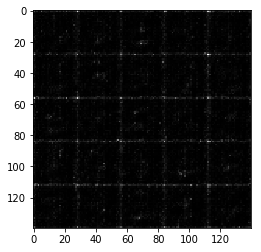

Epoch 1/4... Discriminator Loss: 1.2774... Generator Loss: 0.9240
Epoch 1/4... Discriminator Loss: 1.2817... Generator Loss: 0.6926
Epoch 1/4... Discriminator Loss: 1.4148... Generator Loss: 1.9848
Epoch 1/4... Discriminator Loss: 1.1627... Generator Loss: 1.8019
Epoch 1/4... Discriminator Loss: 1.3101... Generator Loss: 1.1949
Epoch 1/4... Discriminator Loss: 1.2501... Generator Loss: 1.1148
Epoch 1/4... Discriminator Loss: 1.2318... Generator Loss: 0.9608
Epoch 1/4... Discriminator Loss: 1.1687... Generator Loss: 1.1238
Epoch 1/4... Discriminator Loss: 1.2365... Generator Loss: 1.0125
Epoch 1/4... Discriminator Loss: 1.2861... Generator Loss: 1.0269
Epoch 1/4... Discriminator Loss: 1.2105... Generator Loss: 1.2062
Epoch 1/4... Discriminator Loss: 1.4634... Generator Loss: 0.8711
Epoch 1/4... Discriminator Loss: 1.2387... Generator Loss: 0.9890
Epoch 1/4... Discriminator Loss: 1.2708... Generator Loss: 1.2132
Epoch 1/4... Discriminator Loss: 1.2609... Generator Loss: 1.3897


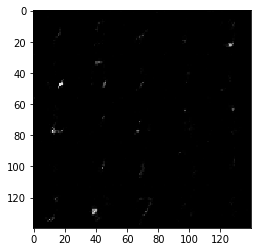

Epoch 1/4... Discriminator Loss: 1.1469... Generator Loss: 1.3967
Epoch 1/4... Discriminator Loss: 1.1780... Generator Loss: 1.2122
Epoch 1/4... Discriminator Loss: 1.2842... Generator Loss: 0.8655
Epoch 1/4... Discriminator Loss: 1.4047... Generator Loss: 1.6219
Epoch 1/4... Discriminator Loss: 1.1998... Generator Loss: 2.0483
Epoch 1/4... Discriminator Loss: 1.3846... Generator Loss: 0.8799
Epoch 1/4... Discriminator Loss: 1.2237... Generator Loss: 0.9402
Epoch 1/4... Discriminator Loss: 1.3464... Generator Loss: 0.6648
Epoch 1/4... Discriminator Loss: 1.1877... Generator Loss: 1.0706
Epoch 1/4... Discriminator Loss: 1.4171... Generator Loss: 1.7770
Epoch 1/4... Discriminator Loss: 1.7593... Generator Loss: 0.6330
Epoch 1/4... Discriminator Loss: 1.4130... Generator Loss: 1.0097
Epoch 1/4... Discriminator Loss: 1.4005... Generator Loss: 1.2324
Epoch 1/4... Discriminator Loss: 1.4833... Generator Loss: 0.6504
Epoch 1/4... Discriminator Loss: 1.2703... Generator Loss: 1.4627


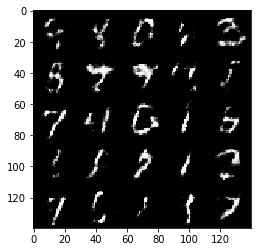

Epoch 1/4... Discriminator Loss: 1.2105... Generator Loss: 1.1406
Epoch 1/4... Discriminator Loss: 1.1670... Generator Loss: 1.1078
Epoch 1/4... Discriminator Loss: 1.4546... Generator Loss: 0.7093
Epoch 1/4... Discriminator Loss: 1.4799... Generator Loss: 1.1150
Epoch 1/4... Discriminator Loss: 1.3671... Generator Loss: 0.7146
Epoch 1/4... Discriminator Loss: 1.6845... Generator Loss: 1.1389
Epoch 1/4... Discriminator Loss: 1.2545... Generator Loss: 1.2615
Epoch 1/4... Discriminator Loss: 1.3754... Generator Loss: 0.8217
Epoch 1/4... Discriminator Loss: 1.2035... Generator Loss: 1.5672
Epoch 1/4... Discriminator Loss: 1.4456... Generator Loss: 1.2311
Epoch 1/4... Discriminator Loss: 1.3280... Generator Loss: 0.7651
Epoch 1/4... Discriminator Loss: 1.3544... Generator Loss: 1.1172
Epoch 1/4... Discriminator Loss: 1.6001... Generator Loss: 2.2292
Epoch 1/4... Discriminator Loss: 1.3460... Generator Loss: 0.9146
Epoch 1/4... Discriminator Loss: 1.4224... Generator Loss: 0.6426


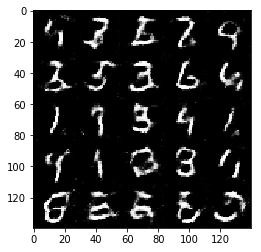

Epoch 1/4... Discriminator Loss: 1.3197... Generator Loss: 0.6937
Epoch 1/4... Discriminator Loss: 1.2807... Generator Loss: 1.3586
Epoch 1/4... Discriminator Loss: 1.2122... Generator Loss: 1.0461
Epoch 1/4... Discriminator Loss: 1.2671... Generator Loss: 1.0062
Epoch 1/4... Discriminator Loss: 1.3190... Generator Loss: 0.8248
Epoch 1/4... Discriminator Loss: 1.2217... Generator Loss: 1.2654
Epoch 1/4... Discriminator Loss: 1.4789... Generator Loss: 1.4592
Epoch 1/4... Discriminator Loss: 1.5049... Generator Loss: 0.6650
Epoch 1/4... Discriminator Loss: 1.3372... Generator Loss: 0.6729
Epoch 1/4... Discriminator Loss: 1.1968... Generator Loss: 0.7908
Epoch 1/4... Discriminator Loss: 1.4253... Generator Loss: 0.7293
Epoch 1/4... Discriminator Loss: 1.1775... Generator Loss: 0.9660
Epoch 1/4... Discriminator Loss: 1.2501... Generator Loss: 1.0276
Epoch 1/4... Discriminator Loss: 1.2176... Generator Loss: 0.7853
Epoch 1/4... Discriminator Loss: 1.3442... Generator Loss: 0.9270


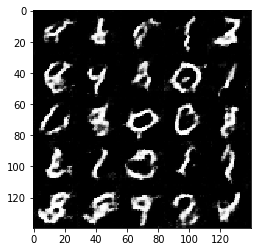

Epoch 1/4... Discriminator Loss: 1.2181... Generator Loss: 1.0295
Epoch 1/4... Discriminator Loss: 1.3110... Generator Loss: 0.8817
Epoch 1/4... Discriminator Loss: 1.1558... Generator Loss: 1.0178
Epoch 1/4... Discriminator Loss: 1.3880... Generator Loss: 0.7172
Epoch 1/4... Discriminator Loss: 1.4050... Generator Loss: 0.6626
Epoch 1/4... Discriminator Loss: 1.1658... Generator Loss: 0.8943
Epoch 1/4... Discriminator Loss: 1.2621... Generator Loss: 0.7932
Epoch 1/4... Discriminator Loss: 1.7121... Generator Loss: 0.5453
Epoch 1/4... Discriminator Loss: 1.2656... Generator Loss: 0.8414
Epoch 1/4... Discriminator Loss: 1.2029... Generator Loss: 0.8483
Epoch 1/4... Discriminator Loss: 1.2631... Generator Loss: 0.7559
Epoch 1/4... Discriminator Loss: 1.2670... Generator Loss: 0.8582
Epoch 1/4... Discriminator Loss: 1.1346... Generator Loss: 0.7992
Epoch 1/4... Discriminator Loss: 1.2215... Generator Loss: 0.8886
Epoch 1/4... Discriminator Loss: 1.3131... Generator Loss: 0.6925


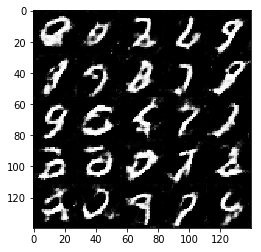

Epoch 1/4... Discriminator Loss: 1.1986... Generator Loss: 1.0301
Epoch 1/4... Discriminator Loss: 1.2638... Generator Loss: 1.6090
Epoch 1/4... Discriminator Loss: 1.3292... Generator Loss: 0.8483
Epoch 1/4... Discriminator Loss: 1.3611... Generator Loss: 0.7715
Epoch 1/4... Discriminator Loss: 1.5369... Generator Loss: 1.6411
Epoch 1/4... Discriminator Loss: 1.3135... Generator Loss: 1.1576
Epoch 1/4... Discriminator Loss: 1.2093... Generator Loss: 0.7157
Epoch 1/4... Discriminator Loss: 1.1415... Generator Loss: 1.2379
Epoch 1/4... Discriminator Loss: 1.2568... Generator Loss: 0.9309
Epoch 1/4... Discriminator Loss: 1.1508... Generator Loss: 1.0043
Epoch 1/4... Discriminator Loss: 1.3635... Generator Loss: 0.6849
Epoch 1/4... Discriminator Loss: 1.2580... Generator Loss: 1.0222
Epoch 1/4... Discriminator Loss: 1.3613... Generator Loss: 0.7386
Epoch 1/4... Discriminator Loss: 1.3175... Generator Loss: 0.6708
Epoch 1/4... Discriminator Loss: 1.1992... Generator Loss: 1.1918


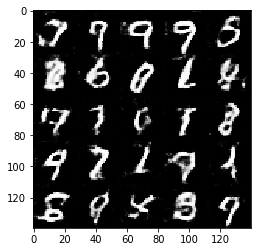

Epoch 1/4... Discriminator Loss: 1.1712... Generator Loss: 1.1250
Epoch 1/4... Discriminator Loss: 1.2618... Generator Loss: 0.9083
Epoch 1/4... Discriminator Loss: 1.1928... Generator Loss: 1.3722
Epoch 1/4... Discriminator Loss: 1.1793... Generator Loss: 1.1631
Epoch 1/4... Discriminator Loss: 1.1738... Generator Loss: 1.0114
Epoch 1/4... Discriminator Loss: 1.3716... Generator Loss: 1.5594
Epoch 1/4... Discriminator Loss: 1.4976... Generator Loss: 0.8476
Epoch 1/4... Discriminator Loss: 1.2182... Generator Loss: 1.0495
Epoch 1/4... Discriminator Loss: 1.3101... Generator Loss: 0.8531
Epoch 1/4... Discriminator Loss: 1.3618... Generator Loss: 1.5049
Epoch 1/4... Discriminator Loss: 1.3232... Generator Loss: 0.7209
Epoch 1/4... Discriminator Loss: 1.2989... Generator Loss: 1.2430
Epoch 1/4... Discriminator Loss: 1.2247... Generator Loss: 1.2732
Epoch 1/4... Discriminator Loss: 1.2212... Generator Loss: 0.9968
Epoch 1/4... Discriminator Loss: 1.1036... Generator Loss: 0.8612


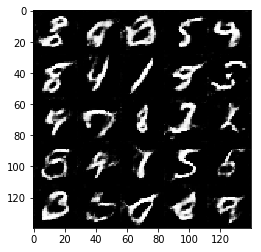

Epoch 1/4... Discriminator Loss: 1.3059... Generator Loss: 1.5950
Epoch 1/4... Discriminator Loss: 1.5542... Generator Loss: 0.6926
Epoch 1/4... Discriminator Loss: 1.3708... Generator Loss: 1.0405
Epoch 1/4... Discriminator Loss: 1.2432... Generator Loss: 0.9340
Epoch 1/4... Discriminator Loss: 1.2128... Generator Loss: 1.4147
Epoch 1/4... Discriminator Loss: 1.2126... Generator Loss: 0.8678
Epoch 1/4... Discriminator Loss: 1.3792... Generator Loss: 1.0375
Epoch 1/4... Discriminator Loss: 1.0216... Generator Loss: 1.0681
Epoch 1/4... Discriminator Loss: 1.2082... Generator Loss: 1.3126
Epoch 1/4... Discriminator Loss: 1.2752... Generator Loss: 0.9208
Epoch 1/4... Discriminator Loss: 1.2319... Generator Loss: 0.9385
Epoch 1/4... Discriminator Loss: 1.2558... Generator Loss: 0.8473
Epoch 1/4... Discriminator Loss: 1.2713... Generator Loss: 1.0119
Epoch 1/4... Discriminator Loss: 1.4091... Generator Loss: 0.8404
Epoch 1/4... Discriminator Loss: 1.2207... Generator Loss: 1.0615


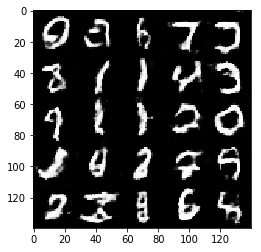

Epoch 1/4... Discriminator Loss: 1.3219... Generator Loss: 1.3487
Epoch 1/4... Discriminator Loss: 1.6845... Generator Loss: 0.5897
Epoch 1/4... Discriminator Loss: 1.2841... Generator Loss: 0.7896
Epoch 1/4... Discriminator Loss: 1.2392... Generator Loss: 0.9815
Epoch 1/4... Discriminator Loss: 1.3089... Generator Loss: 1.1688
Epoch 1/4... Discriminator Loss: 1.0337... Generator Loss: 1.0200
Epoch 1/4... Discriminator Loss: 1.1554... Generator Loss: 1.2674
Epoch 1/4... Discriminator Loss: 1.2424... Generator Loss: 1.1833
Epoch 1/4... Discriminator Loss: 1.1888... Generator Loss: 0.7410
Epoch 1/4... Discriminator Loss: 1.0639... Generator Loss: 0.9713
Epoch 1/4... Discriminator Loss: 1.2619... Generator Loss: 0.9147
Epoch 1/4... Discriminator Loss: 1.1922... Generator Loss: 0.7481
Epoch 1/4... Discriminator Loss: 1.1981... Generator Loss: 1.1816
Epoch 1/4... Discriminator Loss: 1.5235... Generator Loss: 0.7591
Epoch 1/4... Discriminator Loss: 1.1163... Generator Loss: 0.9704


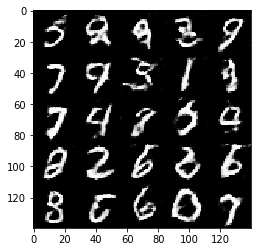

Epoch 1/4... Discriminator Loss: 1.4182... Generator Loss: 0.7093
Epoch 1/4... Discriminator Loss: 1.2085... Generator Loss: 1.0673
Epoch 1/4... Discriminator Loss: 1.4339... Generator Loss: 1.1299
Epoch 1/4... Discriminator Loss: 1.2155... Generator Loss: 0.8270
Epoch 1/4... Discriminator Loss: 1.2723... Generator Loss: 1.5502
Epoch 1/4... Discriminator Loss: 1.5335... Generator Loss: 0.6723
Epoch 1/4... Discriminator Loss: 1.0883... Generator Loss: 1.2448
Epoch 1/4... Discriminator Loss: 1.1675... Generator Loss: 1.2049
Epoch 1/4... Discriminator Loss: 1.1943... Generator Loss: 1.3067
Epoch 1/4... Discriminator Loss: 1.2063... Generator Loss: 0.8800
Epoch 1/4... Discriminator Loss: 1.2192... Generator Loss: 1.2042
Epoch 1/4... Discriminator Loss: 1.2006... Generator Loss: 0.8799
Epoch 1/4... Discriminator Loss: 1.2478... Generator Loss: 0.8210
Epoch 1/4... Discriminator Loss: 1.1416... Generator Loss: 1.3333
Epoch 1/4... Discriminator Loss: 1.2207... Generator Loss: 1.1403


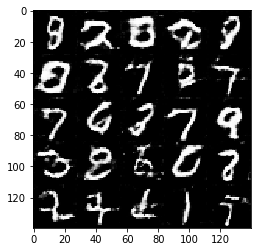

Epoch 1/4... Discriminator Loss: 1.2540... Generator Loss: 1.0309
Epoch 1/4... Discriminator Loss: 1.2949... Generator Loss: 1.2959
Epoch 1/4... Discriminator Loss: 1.1246... Generator Loss: 1.0926
Epoch 1/4... Discriminator Loss: 1.3512... Generator Loss: 0.8514
Epoch 1/4... Discriminator Loss: 1.1538... Generator Loss: 1.0175
Epoch 1/4... Discriminator Loss: 1.1664... Generator Loss: 0.9978
Epoch 1/4... Discriminator Loss: 1.2919... Generator Loss: 1.1193
Epoch 1/4... Discriminator Loss: 1.4358... Generator Loss: 0.5900
Epoch 1/4... Discriminator Loss: 1.2072... Generator Loss: 0.8025
Epoch 1/4... Discriminator Loss: 1.2257... Generator Loss: 0.8202
Epoch 1/4... Discriminator Loss: 1.3871... Generator Loss: 0.7195
Epoch 1/4... Discriminator Loss: 1.5134... Generator Loss: 0.5495
Epoch 1/4... Discriminator Loss: 1.1642... Generator Loss: 1.0672
Epoch 1/4... Discriminator Loss: 1.2552... Generator Loss: 1.0719
Epoch 1/4... Discriminator Loss: 1.3275... Generator Loss: 0.9589


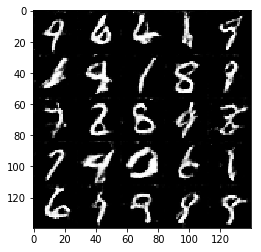

Epoch 1/4... Discriminator Loss: 1.3020... Generator Loss: 0.9335
Epoch 1/4... Discriminator Loss: 1.3004... Generator Loss: 1.1994
Epoch 1/4... Discriminator Loss: 1.3948... Generator Loss: 0.7318
Epoch 1/4... Discriminator Loss: 1.3321... Generator Loss: 0.8642
Epoch 1/4... Discriminator Loss: 1.2092... Generator Loss: 0.8970
Epoch 1/4... Discriminator Loss: 1.3118... Generator Loss: 0.7126
Epoch 1/4... Discriminator Loss: 1.0689... Generator Loss: 1.0472
Epoch 2/4... Discriminator Loss: 1.2078... Generator Loss: 1.0108
Epoch 2/4... Discriminator Loss: 1.3675... Generator Loss: 1.7363
Epoch 2/4... Discriminator Loss: 1.2685... Generator Loss: 1.7533
Epoch 2/4... Discriminator Loss: 1.3988... Generator Loss: 0.7261
Epoch 2/4... Discriminator Loss: 1.1152... Generator Loss: 1.2620
Epoch 2/4... Discriminator Loss: 1.4927... Generator Loss: 1.3638
Epoch 2/4... Discriminator Loss: 1.2906... Generator Loss: 1.1001
Epoch 2/4... Discriminator Loss: 1.2714... Generator Loss: 1.6627


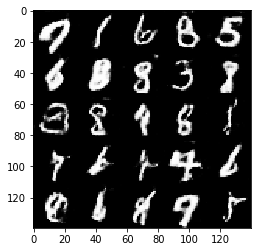

Epoch 2/4... Discriminator Loss: 1.3233... Generator Loss: 1.0557
Epoch 2/4... Discriminator Loss: 1.3157... Generator Loss: 0.6258
Epoch 2/4... Discriminator Loss: 1.4311... Generator Loss: 0.6666
Epoch 2/4... Discriminator Loss: 1.1607... Generator Loss: 1.3665
Epoch 2/4... Discriminator Loss: 1.2116... Generator Loss: 0.7511
Epoch 2/4... Discriminator Loss: 1.2262... Generator Loss: 1.0470
Epoch 2/4... Discriminator Loss: 1.1943... Generator Loss: 0.9530
Epoch 2/4... Discriminator Loss: 1.3278... Generator Loss: 1.0957
Epoch 2/4... Discriminator Loss: 1.2856... Generator Loss: 0.7879
Epoch 2/4... Discriminator Loss: 1.4715... Generator Loss: 1.1402
Epoch 2/4... Discriminator Loss: 1.1909... Generator Loss: 0.8030
Epoch 2/4... Discriminator Loss: 1.2150... Generator Loss: 1.4037
Epoch 2/4... Discriminator Loss: 1.1501... Generator Loss: 0.8787
Epoch 2/4... Discriminator Loss: 1.2138... Generator Loss: 0.9787
Epoch 2/4... Discriminator Loss: 1.2965... Generator Loss: 0.8525


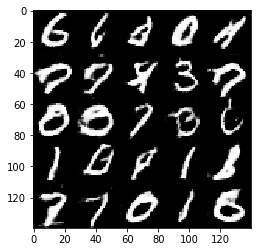

Epoch 2/4... Discriminator Loss: 1.2756... Generator Loss: 0.8813
Epoch 2/4... Discriminator Loss: 1.2285... Generator Loss: 1.0709
Epoch 2/4... Discriminator Loss: 1.1881... Generator Loss: 1.2195
Epoch 2/4... Discriminator Loss: 1.2181... Generator Loss: 0.9369
Epoch 2/4... Discriminator Loss: 1.1941... Generator Loss: 1.3032
Epoch 2/4... Discriminator Loss: 1.1915... Generator Loss: 1.2108
Epoch 2/4... Discriminator Loss: 1.1962... Generator Loss: 1.0132
Epoch 2/4... Discriminator Loss: 1.1262... Generator Loss: 0.8297
Epoch 2/4... Discriminator Loss: 1.1732... Generator Loss: 1.1434
Epoch 2/4... Discriminator Loss: 1.1063... Generator Loss: 1.1627
Epoch 2/4... Discriminator Loss: 1.0797... Generator Loss: 1.4388
Epoch 2/4... Discriminator Loss: 1.1993... Generator Loss: 0.9965
Epoch 2/4... Discriminator Loss: 1.1429... Generator Loss: 1.0265
Epoch 2/4... Discriminator Loss: 1.1551... Generator Loss: 2.0720
Epoch 2/4... Discriminator Loss: 1.1799... Generator Loss: 0.9628


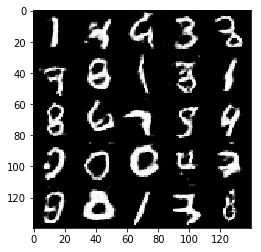

Epoch 2/4... Discriminator Loss: 1.1887... Generator Loss: 0.9612
Epoch 2/4... Discriminator Loss: 1.3005... Generator Loss: 1.5056
Epoch 2/4... Discriminator Loss: 1.2315... Generator Loss: 0.8181
Epoch 2/4... Discriminator Loss: 1.2131... Generator Loss: 1.3600
Epoch 2/4... Discriminator Loss: 1.2436... Generator Loss: 0.8159
Epoch 2/4... Discriminator Loss: 1.3341... Generator Loss: 1.2272
Epoch 2/4... Discriminator Loss: 1.2894... Generator Loss: 1.1588
Epoch 2/4... Discriminator Loss: 1.3777... Generator Loss: 1.4560
Epoch 2/4... Discriminator Loss: 1.2515... Generator Loss: 0.8907
Epoch 2/4... Discriminator Loss: 1.1864... Generator Loss: 1.1613
Epoch 2/4... Discriminator Loss: 1.3063... Generator Loss: 0.7002
Epoch 2/4... Discriminator Loss: 1.0882... Generator Loss: 1.1362
Epoch 2/4... Discriminator Loss: 1.2053... Generator Loss: 0.8851
Epoch 2/4... Discriminator Loss: 1.3945... Generator Loss: 1.7448
Epoch 2/4... Discriminator Loss: 1.4911... Generator Loss: 0.6634


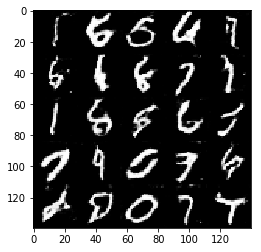

Epoch 2/4... Discriminator Loss: 1.0722... Generator Loss: 1.0230
Epoch 2/4... Discriminator Loss: 1.1254... Generator Loss: 1.1193
Epoch 2/4... Discriminator Loss: 1.2437... Generator Loss: 1.2818
Epoch 2/4... Discriminator Loss: 1.4705... Generator Loss: 1.6718
Epoch 2/4... Discriminator Loss: 1.2676... Generator Loss: 1.5035
Epoch 2/4... Discriminator Loss: 1.1856... Generator Loss: 0.9200
Epoch 2/4... Discriminator Loss: 1.3639... Generator Loss: 0.8909
Epoch 2/4... Discriminator Loss: 1.2112... Generator Loss: 1.3167
Epoch 2/4... Discriminator Loss: 1.3097... Generator Loss: 0.7620
Epoch 2/4... Discriminator Loss: 1.1765... Generator Loss: 0.8576
Epoch 2/4... Discriminator Loss: 1.4936... Generator Loss: 0.5669
Epoch 2/4... Discriminator Loss: 1.5616... Generator Loss: 1.3790
Epoch 2/4... Discriminator Loss: 1.4371... Generator Loss: 0.6352
Epoch 2/4... Discriminator Loss: 1.0746... Generator Loss: 1.2517
Epoch 2/4... Discriminator Loss: 1.2374... Generator Loss: 1.2440


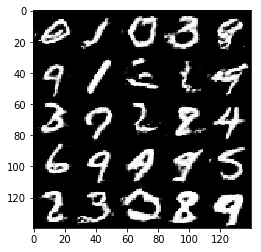

Epoch 2/4... Discriminator Loss: 1.0905... Generator Loss: 0.8434
Epoch 2/4... Discriminator Loss: 1.1165... Generator Loss: 1.0127
Epoch 2/4... Discriminator Loss: 1.2213... Generator Loss: 0.9257
Epoch 2/4... Discriminator Loss: 1.1608... Generator Loss: 1.1818
Epoch 2/4... Discriminator Loss: 1.0781... Generator Loss: 1.3553
Epoch 2/4... Discriminator Loss: 1.1008... Generator Loss: 1.1158
Epoch 2/4... Discriminator Loss: 1.1456... Generator Loss: 1.1081
Epoch 2/4... Discriminator Loss: 1.0759... Generator Loss: 1.2495
Epoch 2/4... Discriminator Loss: 1.3824... Generator Loss: 1.5331
Epoch 2/4... Discriminator Loss: 1.2545... Generator Loss: 1.0480
Epoch 2/4... Discriminator Loss: 1.1421... Generator Loss: 1.0521
Epoch 2/4... Discriminator Loss: 1.1878... Generator Loss: 1.0586
Epoch 2/4... Discriminator Loss: 1.1230... Generator Loss: 1.1326
Epoch 2/4... Discriminator Loss: 1.1339... Generator Loss: 1.0641
Epoch 2/4... Discriminator Loss: 1.2646... Generator Loss: 1.6385


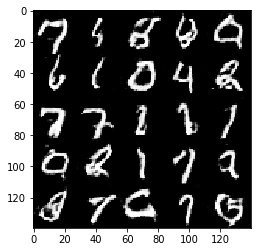

Epoch 2/4... Discriminator Loss: 1.1736... Generator Loss: 1.1303
Epoch 2/4... Discriminator Loss: 1.1581... Generator Loss: 1.0863
Epoch 2/4... Discriminator Loss: 1.4156... Generator Loss: 0.7757
Epoch 2/4... Discriminator Loss: 1.2251... Generator Loss: 1.3532
Epoch 2/4... Discriminator Loss: 1.6075... Generator Loss: 0.6121
Epoch 2/4... Discriminator Loss: 1.0854... Generator Loss: 0.9216
Epoch 2/4... Discriminator Loss: 1.2707... Generator Loss: 1.0117
Epoch 2/4... Discriminator Loss: 1.1502... Generator Loss: 1.3121
Epoch 2/4... Discriminator Loss: 1.4628... Generator Loss: 1.3594
Epoch 2/4... Discriminator Loss: 1.1983... Generator Loss: 0.9477
Epoch 2/4... Discriminator Loss: 1.3016... Generator Loss: 1.2382
Epoch 2/4... Discriminator Loss: 1.2188... Generator Loss: 0.9024
Epoch 2/4... Discriminator Loss: 1.1832... Generator Loss: 1.4748
Epoch 2/4... Discriminator Loss: 1.1373... Generator Loss: 1.4579
Epoch 2/4... Discriminator Loss: 1.1379... Generator Loss: 1.0607


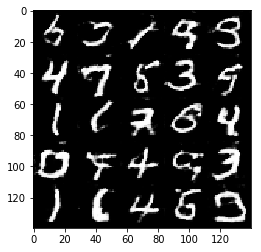

Epoch 2/4... Discriminator Loss: 1.2580... Generator Loss: 1.2904
Epoch 2/4... Discriminator Loss: 1.5755... Generator Loss: 0.6202
Epoch 2/4... Discriminator Loss: 1.1443... Generator Loss: 1.0520
Epoch 2/4... Discriminator Loss: 1.1848... Generator Loss: 1.0874
Epoch 2/4... Discriminator Loss: 1.1766... Generator Loss: 1.1006
Epoch 2/4... Discriminator Loss: 1.2737... Generator Loss: 1.6237
Epoch 2/4... Discriminator Loss: 1.0560... Generator Loss: 0.9461
Epoch 2/4... Discriminator Loss: 1.1492... Generator Loss: 1.1658
Epoch 2/4... Discriminator Loss: 1.6791... Generator Loss: 0.5857
Epoch 2/4... Discriminator Loss: 1.3613... Generator Loss: 2.2994
Epoch 2/4... Discriminator Loss: 1.2280... Generator Loss: 0.9239
Epoch 2/4... Discriminator Loss: 1.2783... Generator Loss: 0.9513
Epoch 2/4... Discriminator Loss: 1.1994... Generator Loss: 0.8906
Epoch 2/4... Discriminator Loss: 1.1507... Generator Loss: 1.0638
Epoch 2/4... Discriminator Loss: 1.3463... Generator Loss: 0.8590


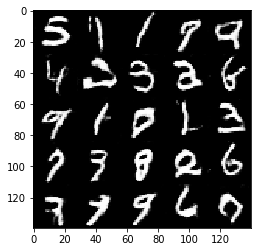

Epoch 2/4... Discriminator Loss: 1.2762... Generator Loss: 0.7162
Epoch 2/4... Discriminator Loss: 1.1424... Generator Loss: 1.3845
Epoch 2/4... Discriminator Loss: 1.1801... Generator Loss: 1.3658
Epoch 2/4... Discriminator Loss: 1.1646... Generator Loss: 0.9827
Epoch 2/4... Discriminator Loss: 1.1574... Generator Loss: 0.9536
Epoch 2/4... Discriminator Loss: 1.0539... Generator Loss: 1.3025
Epoch 2/4... Discriminator Loss: 1.2926... Generator Loss: 1.4750
Epoch 2/4... Discriminator Loss: 1.0871... Generator Loss: 1.2930
Epoch 2/4... Discriminator Loss: 1.1636... Generator Loss: 1.4065
Epoch 2/4... Discriminator Loss: 1.0456... Generator Loss: 1.1502
Epoch 2/4... Discriminator Loss: 1.2401... Generator Loss: 0.8153
Epoch 2/4... Discriminator Loss: 1.2245... Generator Loss: 0.8210
Epoch 2/4... Discriminator Loss: 1.4051... Generator Loss: 0.7245
Epoch 2/4... Discriminator Loss: 1.2146... Generator Loss: 0.6584
Epoch 2/4... Discriminator Loss: 1.2372... Generator Loss: 1.0161


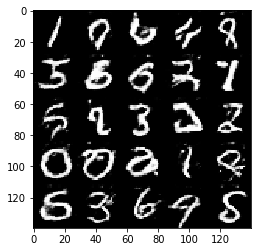

Epoch 2/4... Discriminator Loss: 1.1823... Generator Loss: 1.1398
Epoch 2/4... Discriminator Loss: 1.4748... Generator Loss: 1.6707
Epoch 2/4... Discriminator Loss: 1.1894... Generator Loss: 1.2102
Epoch 2/4... Discriminator Loss: 1.2134... Generator Loss: 0.9685
Epoch 2/4... Discriminator Loss: 1.1414... Generator Loss: 1.1502
Epoch 2/4... Discriminator Loss: 1.2444... Generator Loss: 0.8632
Epoch 2/4... Discriminator Loss: 1.2065... Generator Loss: 0.8949
Epoch 2/4... Discriminator Loss: 1.1569... Generator Loss: 1.0961
Epoch 2/4... Discriminator Loss: 1.1720... Generator Loss: 1.4538
Epoch 2/4... Discriminator Loss: 1.2476... Generator Loss: 0.8586
Epoch 2/4... Discriminator Loss: 1.1154... Generator Loss: 0.9368
Epoch 2/4... Discriminator Loss: 1.1794... Generator Loss: 1.2782
Epoch 2/4... Discriminator Loss: 1.1886... Generator Loss: 1.2984
Epoch 2/4... Discriminator Loss: 1.2054... Generator Loss: 0.8629
Epoch 2/4... Discriminator Loss: 1.1844... Generator Loss: 1.0704


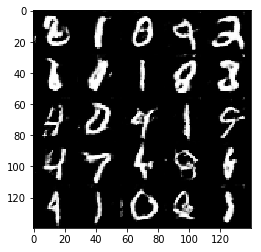

Epoch 2/4... Discriminator Loss: 1.2431... Generator Loss: 0.8765
Epoch 2/4... Discriminator Loss: 1.1452... Generator Loss: 1.0926
Epoch 2/4... Discriminator Loss: 1.1846... Generator Loss: 1.0258
Epoch 2/4... Discriminator Loss: 1.2743... Generator Loss: 0.9318
Epoch 2/4... Discriminator Loss: 1.1931... Generator Loss: 0.8200
Epoch 2/4... Discriminator Loss: 1.1254... Generator Loss: 1.0007
Epoch 2/4... Discriminator Loss: 1.0487... Generator Loss: 1.1154
Epoch 2/4... Discriminator Loss: 1.2514... Generator Loss: 1.0293
Epoch 2/4... Discriminator Loss: 1.1131... Generator Loss: 1.5677
Epoch 2/4... Discriminator Loss: 1.5987... Generator Loss: 1.7458
Epoch 2/4... Discriminator Loss: 1.3158... Generator Loss: 0.8947
Epoch 2/4... Discriminator Loss: 1.2056... Generator Loss: 1.0741
Epoch 2/4... Discriminator Loss: 1.2479... Generator Loss: 0.9160
Epoch 2/4... Discriminator Loss: 1.3459... Generator Loss: 0.8778
Epoch 2/4... Discriminator Loss: 1.0672... Generator Loss: 1.2127


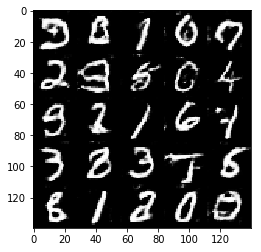

Epoch 2/4... Discriminator Loss: 1.1402... Generator Loss: 1.2109
Epoch 2/4... Discriminator Loss: 1.1301... Generator Loss: 1.5081
Epoch 2/4... Discriminator Loss: 1.2403... Generator Loss: 0.9611
Epoch 2/4... Discriminator Loss: 1.4479... Generator Loss: 0.6453
Epoch 2/4... Discriminator Loss: 1.2530... Generator Loss: 0.9040
Epoch 2/4... Discriminator Loss: 1.5981... Generator Loss: 0.6471
Epoch 2/4... Discriminator Loss: 1.2194... Generator Loss: 1.6924
Epoch 2/4... Discriminator Loss: 1.2012... Generator Loss: 0.8533
Epoch 2/4... Discriminator Loss: 1.3199... Generator Loss: 1.5874
Epoch 2/4... Discriminator Loss: 1.1233... Generator Loss: 1.3923
Epoch 2/4... Discriminator Loss: 1.1274... Generator Loss: 1.5434
Epoch 2/4... Discriminator Loss: 1.1568... Generator Loss: 1.0730
Epoch 2/4... Discriminator Loss: 1.1825... Generator Loss: 1.2274
Epoch 2/4... Discriminator Loss: 1.3343... Generator Loss: 0.5963
Epoch 2/4... Discriminator Loss: 1.2746... Generator Loss: 0.7206


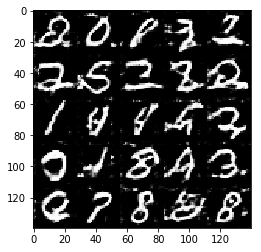

Epoch 2/4... Discriminator Loss: 1.2793... Generator Loss: 0.9560
Epoch 2/4... Discriminator Loss: 1.1906... Generator Loss: 1.0775
Epoch 2/4... Discriminator Loss: 1.0163... Generator Loss: 1.1034
Epoch 2/4... Discriminator Loss: 1.1836... Generator Loss: 0.7478
Epoch 2/4... Discriminator Loss: 1.1674... Generator Loss: 0.8598
Epoch 2/4... Discriminator Loss: 1.3965... Generator Loss: 0.6810
Epoch 2/4... Discriminator Loss: 1.4080... Generator Loss: 2.1941
Epoch 2/4... Discriminator Loss: 1.2007... Generator Loss: 0.9252
Epoch 2/4... Discriminator Loss: 1.3453... Generator Loss: 0.9775
Epoch 2/4... Discriminator Loss: 1.1567... Generator Loss: 1.0489
Epoch 2/4... Discriminator Loss: 1.0844... Generator Loss: 1.0676
Epoch 2/4... Discriminator Loss: 1.0924... Generator Loss: 1.3698
Epoch 2/4... Discriminator Loss: 1.1248... Generator Loss: 1.2757
Epoch 2/4... Discriminator Loss: 1.1386... Generator Loss: 1.2323
Epoch 2/4... Discriminator Loss: 1.0087... Generator Loss: 1.1908


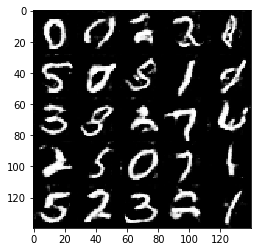

Epoch 3/4... Discriminator Loss: 1.1741... Generator Loss: 1.0317
Epoch 3/4... Discriminator Loss: 1.2496... Generator Loss: 0.9477
Epoch 3/4... Discriminator Loss: 1.1816... Generator Loss: 2.0258
Epoch 3/4... Discriminator Loss: 1.1588... Generator Loss: 1.2308
Epoch 3/4... Discriminator Loss: 1.1460... Generator Loss: 0.9773
Epoch 3/4... Discriminator Loss: 1.2243... Generator Loss: 1.2691
Epoch 3/4... Discriminator Loss: 1.2282... Generator Loss: 0.8015
Epoch 3/4... Discriminator Loss: 1.1443... Generator Loss: 1.0372
Epoch 3/4... Discriminator Loss: 1.2150... Generator Loss: 1.0111
Epoch 3/4... Discriminator Loss: 1.4178... Generator Loss: 0.6742
Epoch 3/4... Discriminator Loss: 1.1584... Generator Loss: 0.9907
Epoch 3/4... Discriminator Loss: 1.0561... Generator Loss: 1.1428
Epoch 3/4... Discriminator Loss: 1.6121... Generator Loss: 0.6082
Epoch 3/4... Discriminator Loss: 1.2119... Generator Loss: 0.9084
Epoch 3/4... Discriminator Loss: 1.2951... Generator Loss: 0.6958


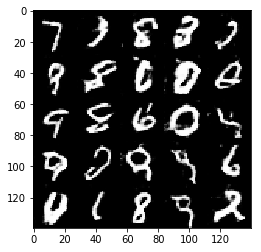

Epoch 3/4... Discriminator Loss: 1.5476... Generator Loss: 0.7180
Epoch 3/4... Discriminator Loss: 1.3170... Generator Loss: 0.8137
Epoch 3/4... Discriminator Loss: 1.3138... Generator Loss: 0.9065
Epoch 3/4... Discriminator Loss: 1.0301... Generator Loss: 1.8190
Epoch 3/4... Discriminator Loss: 1.2733... Generator Loss: 1.1422
Epoch 3/4... Discriminator Loss: 1.3334... Generator Loss: 0.8412
Epoch 3/4... Discriminator Loss: 1.2620... Generator Loss: 0.7392
Epoch 3/4... Discriminator Loss: 1.0441... Generator Loss: 1.4342
Epoch 3/4... Discriminator Loss: 1.1159... Generator Loss: 0.9431
Epoch 3/4... Discriminator Loss: 1.1976... Generator Loss: 1.0546
Epoch 3/4... Discriminator Loss: 1.2348... Generator Loss: 0.9839
Epoch 3/4... Discriminator Loss: 1.2184... Generator Loss: 1.3369
Epoch 3/4... Discriminator Loss: 1.1186... Generator Loss: 1.2243
Epoch 3/4... Discriminator Loss: 1.2083... Generator Loss: 0.9013
Epoch 3/4... Discriminator Loss: 1.2649... Generator Loss: 1.4228


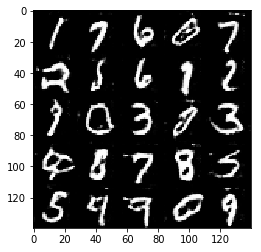

Epoch 3/4... Discriminator Loss: 1.1663... Generator Loss: 2.2353
Epoch 3/4... Discriminator Loss: 1.2528... Generator Loss: 0.6958
Epoch 3/4... Discriminator Loss: 1.1310... Generator Loss: 1.0588
Epoch 3/4... Discriminator Loss: 1.1056... Generator Loss: 1.2019
Epoch 3/4... Discriminator Loss: 1.2386... Generator Loss: 0.9066
Epoch 3/4... Discriminator Loss: 1.1957... Generator Loss: 1.0493
Epoch 3/4... Discriminator Loss: 1.0017... Generator Loss: 1.1851
Epoch 3/4... Discriminator Loss: 1.2675... Generator Loss: 0.7576
Epoch 3/4... Discriminator Loss: 1.1104... Generator Loss: 1.5212
Epoch 3/4... Discriminator Loss: 1.2356... Generator Loss: 0.9334
Epoch 3/4... Discriminator Loss: 1.2296... Generator Loss: 0.9865
Epoch 3/4... Discriminator Loss: 1.1297... Generator Loss: 1.3234
Epoch 3/4... Discriminator Loss: 1.2266... Generator Loss: 1.5295
Epoch 3/4... Discriminator Loss: 1.1346... Generator Loss: 1.4762
Epoch 3/4... Discriminator Loss: 0.9959... Generator Loss: 1.2336


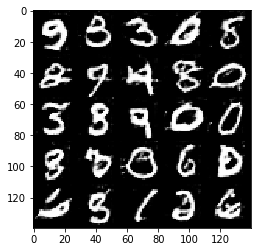

Epoch 3/4... Discriminator Loss: 1.1243... Generator Loss: 1.1215
Epoch 3/4... Discriminator Loss: 1.2886... Generator Loss: 0.7536
Epoch 3/4... Discriminator Loss: 1.2645... Generator Loss: 0.8149
Epoch 3/4... Discriminator Loss: 1.2812... Generator Loss: 0.7461
Epoch 3/4... Discriminator Loss: 1.1824... Generator Loss: 1.0275
Epoch 3/4... Discriminator Loss: 1.2084... Generator Loss: 1.1792
Epoch 3/4... Discriminator Loss: 1.0690... Generator Loss: 1.0537
Epoch 3/4... Discriminator Loss: 1.0224... Generator Loss: 1.5333
Epoch 3/4... Discriminator Loss: 1.1928... Generator Loss: 1.1536
Epoch 3/4... Discriminator Loss: 1.2046... Generator Loss: 1.4880
Epoch 3/4... Discriminator Loss: 1.1134... Generator Loss: 1.1957
Epoch 3/4... Discriminator Loss: 1.1732... Generator Loss: 1.6848
Epoch 3/4... Discriminator Loss: 1.0369... Generator Loss: 1.3801
Epoch 3/4... Discriminator Loss: 1.1777... Generator Loss: 0.8351
Epoch 3/4... Discriminator Loss: 1.1356... Generator Loss: 1.7519


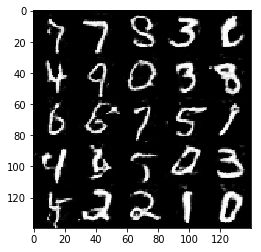

Epoch 3/4... Discriminator Loss: 1.2465... Generator Loss: 0.7761
Epoch 3/4... Discriminator Loss: 1.3107... Generator Loss: 0.7908
Epoch 3/4... Discriminator Loss: 1.2893... Generator Loss: 0.9111
Epoch 3/4... Discriminator Loss: 1.3844... Generator Loss: 0.7419
Epoch 3/4... Discriminator Loss: 1.1075... Generator Loss: 1.4786
Epoch 3/4... Discriminator Loss: 1.2279... Generator Loss: 1.1962
Epoch 3/4... Discriminator Loss: 1.1748... Generator Loss: 0.9457
Epoch 3/4... Discriminator Loss: 1.0942... Generator Loss: 0.9007
Epoch 3/4... Discriminator Loss: 1.1928... Generator Loss: 1.1564
Epoch 3/4... Discriminator Loss: 1.1421... Generator Loss: 1.5653
Epoch 3/4... Discriminator Loss: 1.2846... Generator Loss: 0.9660
Epoch 3/4... Discriminator Loss: 1.2026... Generator Loss: 1.2417
Epoch 3/4... Discriminator Loss: 1.1652... Generator Loss: 0.7711
Epoch 3/4... Discriminator Loss: 1.0287... Generator Loss: 1.4353
Epoch 3/4... Discriminator Loss: 1.1922... Generator Loss: 0.8258


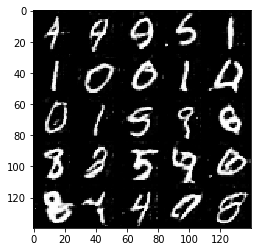

Epoch 3/4... Discriminator Loss: 1.0675... Generator Loss: 1.0764
Epoch 3/4... Discriminator Loss: 1.0936... Generator Loss: 1.1253
Epoch 3/4... Discriminator Loss: 0.9995... Generator Loss: 1.3701
Epoch 3/4... Discriminator Loss: 1.2240... Generator Loss: 0.8657
Epoch 3/4... Discriminator Loss: 1.1789... Generator Loss: 0.8405
Epoch 3/4... Discriminator Loss: 1.2060... Generator Loss: 1.1310
Epoch 3/4... Discriminator Loss: 1.2151... Generator Loss: 0.9782
Epoch 3/4... Discriminator Loss: 1.0927... Generator Loss: 1.2207
Epoch 3/4... Discriminator Loss: 1.3579... Generator Loss: 1.1170
Epoch 3/4... Discriminator Loss: 1.1836... Generator Loss: 1.0834
Epoch 3/4... Discriminator Loss: 1.0750... Generator Loss: 1.1459
Epoch 3/4... Discriminator Loss: 1.0867... Generator Loss: 1.0892
Epoch 3/4... Discriminator Loss: 1.2078... Generator Loss: 1.1150
Epoch 3/4... Discriminator Loss: 1.1962... Generator Loss: 1.1340
Epoch 3/4... Discriminator Loss: 0.9910... Generator Loss: 1.4725


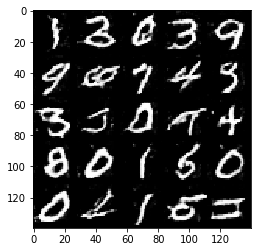

Epoch 3/4... Discriminator Loss: 1.1505... Generator Loss: 0.8180
Epoch 3/4... Discriminator Loss: 1.3415... Generator Loss: 1.6226
Epoch 3/4... Discriminator Loss: 1.2451... Generator Loss: 1.0545
Epoch 3/4... Discriminator Loss: 1.4277... Generator Loss: 1.5290
Epoch 3/4... Discriminator Loss: 1.3046... Generator Loss: 1.1976
Epoch 3/4... Discriminator Loss: 1.0870... Generator Loss: 1.6637
Epoch 3/4... Discriminator Loss: 1.0326... Generator Loss: 1.4485
Epoch 3/4... Discriminator Loss: 1.1854... Generator Loss: 0.9093
Epoch 3/4... Discriminator Loss: 1.2539... Generator Loss: 1.0861
Epoch 3/4... Discriminator Loss: 1.0910... Generator Loss: 1.2346
Epoch 3/4... Discriminator Loss: 0.9913... Generator Loss: 1.3607
Epoch 3/4... Discriminator Loss: 1.1083... Generator Loss: 1.2184
Epoch 3/4... Discriminator Loss: 1.1038... Generator Loss: 1.7269
Epoch 3/4... Discriminator Loss: 1.3510... Generator Loss: 0.5716
Epoch 3/4... Discriminator Loss: 1.2657... Generator Loss: 0.9783


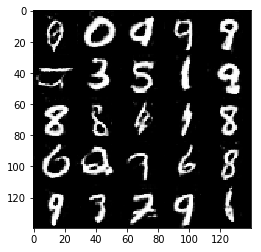

Epoch 3/4... Discriminator Loss: 1.2794... Generator Loss: 0.8351
Epoch 3/4... Discriminator Loss: 1.1344... Generator Loss: 1.1828
Epoch 3/4... Discriminator Loss: 1.1286... Generator Loss: 0.8314
Epoch 3/4... Discriminator Loss: 1.0941... Generator Loss: 2.3772
Epoch 3/4... Discriminator Loss: 1.1513... Generator Loss: 1.7753
Epoch 3/4... Discriminator Loss: 1.3435... Generator Loss: 1.7083
Epoch 3/4... Discriminator Loss: 1.1912... Generator Loss: 1.1797
Epoch 3/4... Discriminator Loss: 1.1073... Generator Loss: 1.0158
Epoch 3/4... Discriminator Loss: 1.1349... Generator Loss: 1.0191
Epoch 3/4... Discriminator Loss: 1.1527... Generator Loss: 0.9228
Epoch 3/4... Discriminator Loss: 1.2193... Generator Loss: 1.3629
Epoch 3/4... Discriminator Loss: 1.1664... Generator Loss: 1.0166
Epoch 3/4... Discriminator Loss: 1.0952... Generator Loss: 0.9942
Epoch 3/4... Discriminator Loss: 1.0215... Generator Loss: 1.9683
Epoch 3/4... Discriminator Loss: 1.1584... Generator Loss: 1.0355


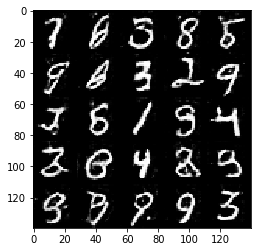

Epoch 3/4... Discriminator Loss: 1.1400... Generator Loss: 1.1149
Epoch 3/4... Discriminator Loss: 1.3343... Generator Loss: 0.7024
Epoch 3/4... Discriminator Loss: 1.1937... Generator Loss: 1.8196
Epoch 3/4... Discriminator Loss: 1.0281... Generator Loss: 1.3233
Epoch 3/4... Discriminator Loss: 0.9458... Generator Loss: 1.4010
Epoch 3/4... Discriminator Loss: 1.2221... Generator Loss: 1.0989
Epoch 3/4... Discriminator Loss: 1.1942... Generator Loss: 1.1108
Epoch 3/4... Discriminator Loss: 1.0193... Generator Loss: 1.0848
Epoch 3/4... Discriminator Loss: 1.1298... Generator Loss: 1.1707
Epoch 3/4... Discriminator Loss: 1.3272... Generator Loss: 0.7785
Epoch 3/4... Discriminator Loss: 1.0028... Generator Loss: 1.2907
Epoch 3/4... Discriminator Loss: 1.0196... Generator Loss: 1.1122
Epoch 3/4... Discriminator Loss: 1.1488... Generator Loss: 1.7632
Epoch 3/4... Discriminator Loss: 1.0052... Generator Loss: 1.3034
Epoch 3/4... Discriminator Loss: 1.0426... Generator Loss: 1.0739


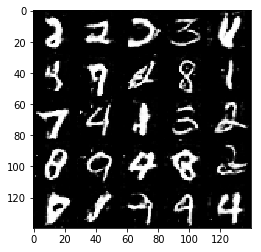

Epoch 3/4... Discriminator Loss: 1.5000... Generator Loss: 0.7268
Epoch 3/4... Discriminator Loss: 1.1371... Generator Loss: 0.9219
Epoch 3/4... Discriminator Loss: 1.2898... Generator Loss: 2.6249
Epoch 3/4... Discriminator Loss: 0.9772... Generator Loss: 1.5204
Epoch 3/4... Discriminator Loss: 1.2881... Generator Loss: 0.9053
Epoch 3/4... Discriminator Loss: 1.3730... Generator Loss: 1.2034
Epoch 3/4... Discriminator Loss: 1.2395... Generator Loss: 0.8242
Epoch 3/4... Discriminator Loss: 1.2005... Generator Loss: 0.8828
Epoch 3/4... Discriminator Loss: 1.2647... Generator Loss: 0.9306
Epoch 3/4... Discriminator Loss: 1.0574... Generator Loss: 1.4591
Epoch 3/4... Discriminator Loss: 1.3298... Generator Loss: 1.6196
Epoch 3/4... Discriminator Loss: 1.0931... Generator Loss: 0.9738
Epoch 3/4... Discriminator Loss: 1.2253... Generator Loss: 0.9407
Epoch 3/4... Discriminator Loss: 1.3575... Generator Loss: 0.5783
Epoch 3/4... Discriminator Loss: 1.0738... Generator Loss: 1.5674


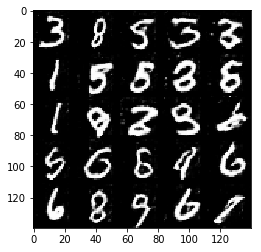

Epoch 3/4... Discriminator Loss: 1.5484... Generator Loss: 0.6708
Epoch 3/4... Discriminator Loss: 1.1285... Generator Loss: 1.4503
Epoch 3/4... Discriminator Loss: 1.1422... Generator Loss: 1.2540
Epoch 3/4... Discriminator Loss: 0.9856... Generator Loss: 1.6581
Epoch 3/4... Discriminator Loss: 1.0486... Generator Loss: 1.0801
Epoch 3/4... Discriminator Loss: 1.5271... Generator Loss: 1.9005
Epoch 3/4... Discriminator Loss: 1.0199... Generator Loss: 1.3597
Epoch 3/4... Discriminator Loss: 1.1523... Generator Loss: 0.9474
Epoch 3/4... Discriminator Loss: 1.0954... Generator Loss: 1.2039
Epoch 3/4... Discriminator Loss: 1.0107... Generator Loss: 1.5944
Epoch 3/4... Discriminator Loss: 1.2423... Generator Loss: 0.8314
Epoch 3/4... Discriminator Loss: 1.2138... Generator Loss: 0.8282
Epoch 3/4... Discriminator Loss: 0.9909... Generator Loss: 1.2614
Epoch 3/4... Discriminator Loss: 1.0771... Generator Loss: 1.2603
Epoch 3/4... Discriminator Loss: 1.1080... Generator Loss: 1.2129


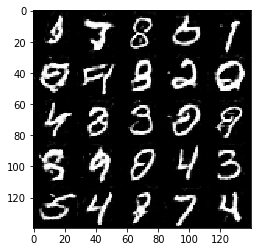

Epoch 3/4... Discriminator Loss: 1.1134... Generator Loss: 1.4082
Epoch 3/4... Discriminator Loss: 1.2629... Generator Loss: 0.9257
Epoch 3/4... Discriminator Loss: 1.0206... Generator Loss: 1.8532
Epoch 3/4... Discriminator Loss: 1.0270... Generator Loss: 1.4602
Epoch 3/4... Discriminator Loss: 1.1989... Generator Loss: 1.0466
Epoch 3/4... Discriminator Loss: 1.0205... Generator Loss: 1.1432
Epoch 3/4... Discriminator Loss: 1.2281... Generator Loss: 1.4882
Epoch 3/4... Discriminator Loss: 1.1034... Generator Loss: 0.8241
Epoch 3/4... Discriminator Loss: 1.2283... Generator Loss: 0.9526
Epoch 3/4... Discriminator Loss: 1.0832... Generator Loss: 1.2599
Epoch 3/4... Discriminator Loss: 1.1856... Generator Loss: 1.1645
Epoch 3/4... Discriminator Loss: 1.1492... Generator Loss: 1.1208
Epoch 3/4... Discriminator Loss: 1.0739... Generator Loss: 1.1478
Epoch 3/4... Discriminator Loss: 0.9817... Generator Loss: 1.4592
Epoch 3/4... Discriminator Loss: 1.1115... Generator Loss: 1.6956


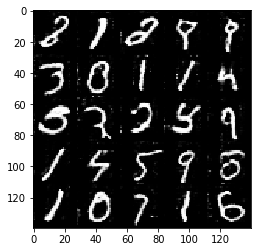

Epoch 3/4... Discriminator Loss: 1.0985... Generator Loss: 1.1197
Epoch 3/4... Discriminator Loss: 1.0862... Generator Loss: 0.9409
Epoch 3/4... Discriminator Loss: 0.9779... Generator Loss: 1.7219
Epoch 3/4... Discriminator Loss: 1.1069... Generator Loss: 1.4177
Epoch 3/4... Discriminator Loss: 1.2541... Generator Loss: 0.9530
Epoch 3/4... Discriminator Loss: 1.3566... Generator Loss: 0.7048
Epoch 3/4... Discriminator Loss: 1.1190... Generator Loss: 1.8578
Epoch 4/4... Discriminator Loss: 1.0086... Generator Loss: 1.3837
Epoch 4/4... Discriminator Loss: 1.2472... Generator Loss: 0.7733
Epoch 4/4... Discriminator Loss: 1.0465... Generator Loss: 1.7356
Epoch 4/4... Discriminator Loss: 1.0697... Generator Loss: 1.5249
Epoch 4/4... Discriminator Loss: 1.3840... Generator Loss: 0.7686
Epoch 4/4... Discriminator Loss: 1.1116... Generator Loss: 1.3497
Epoch 4/4... Discriminator Loss: 1.1175... Generator Loss: 1.0370
Epoch 4/4... Discriminator Loss: 1.2014... Generator Loss: 1.0471


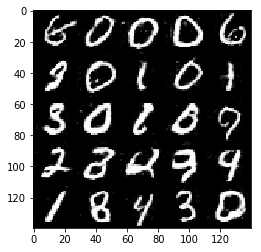

Epoch 4/4... Discriminator Loss: 1.1347... Generator Loss: 1.5860
Epoch 4/4... Discriminator Loss: 1.1128... Generator Loss: 0.9906
Epoch 4/4... Discriminator Loss: 1.2202... Generator Loss: 0.9083
Epoch 4/4... Discriminator Loss: 1.1209... Generator Loss: 0.9491
Epoch 4/4... Discriminator Loss: 1.0999... Generator Loss: 0.9432
Epoch 4/4... Discriminator Loss: 1.2389... Generator Loss: 1.1588
Epoch 4/4... Discriminator Loss: 1.3693... Generator Loss: 0.7718
Epoch 4/4... Discriminator Loss: 1.0902... Generator Loss: 1.0282
Epoch 4/4... Discriminator Loss: 1.2915... Generator Loss: 1.0624
Epoch 4/4... Discriminator Loss: 1.4523... Generator Loss: 0.8546
Epoch 4/4... Discriminator Loss: 1.2583... Generator Loss: 0.7816
Epoch 4/4... Discriminator Loss: 1.0695... Generator Loss: 1.2946
Epoch 4/4... Discriminator Loss: 1.4625... Generator Loss: 0.6907
Epoch 4/4... Discriminator Loss: 1.2341... Generator Loss: 1.3061
Epoch 4/4... Discriminator Loss: 1.1880... Generator Loss: 1.4275


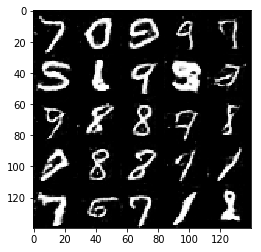

Epoch 4/4... Discriminator Loss: 1.2809... Generator Loss: 0.7683
Epoch 4/4... Discriminator Loss: 1.0515... Generator Loss: 1.4393
Epoch 4/4... Discriminator Loss: 1.1978... Generator Loss: 0.8502
Epoch 4/4... Discriminator Loss: 1.1918... Generator Loss: 0.8622
Epoch 4/4... Discriminator Loss: 1.0688... Generator Loss: 1.5904
Epoch 4/4... Discriminator Loss: 1.1383... Generator Loss: 1.0125
Epoch 4/4... Discriminator Loss: 1.0236... Generator Loss: 1.0816
Epoch 4/4... Discriminator Loss: 1.0895... Generator Loss: 1.5045
Epoch 4/4... Discriminator Loss: 1.0141... Generator Loss: 1.3324
Epoch 4/4... Discriminator Loss: 1.2080... Generator Loss: 0.9706
Epoch 4/4... Discriminator Loss: 1.1244... Generator Loss: 1.6977
Epoch 4/4... Discriminator Loss: 1.0057... Generator Loss: 1.5245
Epoch 4/4... Discriminator Loss: 1.1309... Generator Loss: 1.7643
Epoch 4/4... Discriminator Loss: 1.2954... Generator Loss: 2.6444
Epoch 4/4... Discriminator Loss: 1.2231... Generator Loss: 0.8819


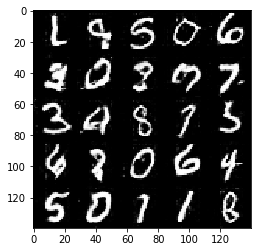

Epoch 4/4... Discriminator Loss: 1.0612... Generator Loss: 1.4006
Epoch 4/4... Discriminator Loss: 1.1528... Generator Loss: 0.7529
Epoch 4/4... Discriminator Loss: 1.0117... Generator Loss: 1.3331
Epoch 4/4... Discriminator Loss: 1.2336... Generator Loss: 1.2929
Epoch 4/4... Discriminator Loss: 1.0350... Generator Loss: 1.9289
Epoch 4/4... Discriminator Loss: 1.1618... Generator Loss: 1.4952
Epoch 4/4... Discriminator Loss: 1.1537... Generator Loss: 1.7219
Epoch 4/4... Discriminator Loss: 1.1574... Generator Loss: 1.6351
Epoch 4/4... Discriminator Loss: 1.1609... Generator Loss: 0.8579
Epoch 4/4... Discriminator Loss: 1.1400... Generator Loss: 1.1992
Epoch 4/4... Discriminator Loss: 1.5911... Generator Loss: 0.7354
Epoch 4/4... Discriminator Loss: 1.1457... Generator Loss: 1.6104
Epoch 4/4... Discriminator Loss: 1.1338... Generator Loss: 1.1242
Epoch 4/4... Discriminator Loss: 1.1979... Generator Loss: 1.0432
Epoch 4/4... Discriminator Loss: 1.0735... Generator Loss: 0.8761


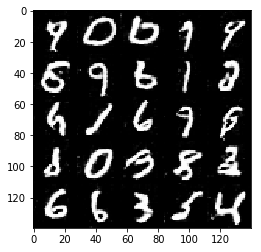

Epoch 4/4... Discriminator Loss: 1.1121... Generator Loss: 1.0224
Epoch 4/4... Discriminator Loss: 1.1730... Generator Loss: 1.9501
Epoch 4/4... Discriminator Loss: 0.9704... Generator Loss: 1.2686
Epoch 4/4... Discriminator Loss: 1.1537... Generator Loss: 1.8766
Epoch 4/4... Discriminator Loss: 1.0611... Generator Loss: 1.0870
Epoch 4/4... Discriminator Loss: 1.0300... Generator Loss: 1.3797
Epoch 4/4... Discriminator Loss: 1.2942... Generator Loss: 1.0049
Epoch 4/4... Discriminator Loss: 1.2350... Generator Loss: 0.7482
Epoch 4/4... Discriminator Loss: 1.2022... Generator Loss: 1.0847
Epoch 4/4... Discriminator Loss: 1.3076... Generator Loss: 1.5089
Epoch 4/4... Discriminator Loss: 1.1578... Generator Loss: 1.3075
Epoch 4/4... Discriminator Loss: 1.1248... Generator Loss: 1.4482
Epoch 4/4... Discriminator Loss: 1.2769... Generator Loss: 0.8946
Epoch 4/4... Discriminator Loss: 1.0873... Generator Loss: 1.0195
Epoch 4/4... Discriminator Loss: 1.1196... Generator Loss: 1.0716


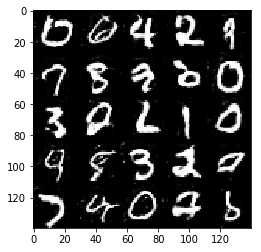

Epoch 4/4... Discriminator Loss: 1.0763... Generator Loss: 1.1909
Epoch 4/4... Discriminator Loss: 0.9802... Generator Loss: 1.7618
Epoch 4/4... Discriminator Loss: 0.9832... Generator Loss: 1.3340
Epoch 4/4... Discriminator Loss: 1.6419... Generator Loss: 1.6525
Epoch 4/4... Discriminator Loss: 1.1972... Generator Loss: 1.4803
Epoch 4/4... Discriminator Loss: 1.0481... Generator Loss: 1.4455
Epoch 4/4... Discriminator Loss: 1.0503... Generator Loss: 1.2880
Epoch 4/4... Discriminator Loss: 1.0303... Generator Loss: 1.2516
Epoch 4/4... Discriminator Loss: 1.3826... Generator Loss: 0.7963
Epoch 4/4... Discriminator Loss: 1.0422... Generator Loss: 1.1672
Epoch 4/4... Discriminator Loss: 1.1519... Generator Loss: 2.1064
Epoch 4/4... Discriminator Loss: 1.2155... Generator Loss: 2.3038
Epoch 4/4... Discriminator Loss: 1.2346... Generator Loss: 1.2969
Epoch 4/4... Discriminator Loss: 1.0298... Generator Loss: 1.4987
Epoch 4/4... Discriminator Loss: 1.2317... Generator Loss: 0.9221


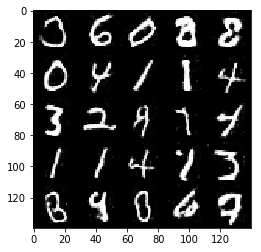

Epoch 4/4... Discriminator Loss: 0.9871... Generator Loss: 1.3678
Epoch 4/4... Discriminator Loss: 1.1634... Generator Loss: 1.3074
Epoch 4/4... Discriminator Loss: 2.1497... Generator Loss: 0.5819
Epoch 4/4... Discriminator Loss: 1.1550... Generator Loss: 1.9823
Epoch 4/4... Discriminator Loss: 1.1519... Generator Loss: 1.2642
Epoch 4/4... Discriminator Loss: 1.0824... Generator Loss: 1.1793
Epoch 4/4... Discriminator Loss: 1.0450... Generator Loss: 1.2734
Epoch 4/4... Discriminator Loss: 1.0805... Generator Loss: 1.4910
Epoch 4/4... Discriminator Loss: 1.5782... Generator Loss: 0.4869
Epoch 4/4... Discriminator Loss: 1.2333... Generator Loss: 1.1662
Epoch 4/4... Discriminator Loss: 1.1572... Generator Loss: 0.7606
Epoch 4/4... Discriminator Loss: 1.2244... Generator Loss: 0.8888
Epoch 4/4... Discriminator Loss: 1.0170... Generator Loss: 1.3260
Epoch 4/4... Discriminator Loss: 1.0936... Generator Loss: 1.1238
Epoch 4/4... Discriminator Loss: 1.1017... Generator Loss: 1.1404


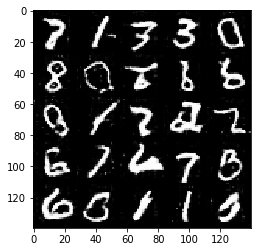

Epoch 4/4... Discriminator Loss: 1.0196... Generator Loss: 1.2777
Epoch 4/4... Discriminator Loss: 1.0193... Generator Loss: 1.0093
Epoch 4/4... Discriminator Loss: 1.1580... Generator Loss: 1.4598
Epoch 4/4... Discriminator Loss: 1.1294... Generator Loss: 0.8865
Epoch 4/4... Discriminator Loss: 1.1128... Generator Loss: 0.9500
Epoch 4/4... Discriminator Loss: 1.0490... Generator Loss: 1.0445
Epoch 4/4... Discriminator Loss: 1.1883... Generator Loss: 1.0473
Epoch 4/4... Discriminator Loss: 0.9781... Generator Loss: 1.0656
Epoch 4/4... Discriminator Loss: 1.0456... Generator Loss: 1.2521
Epoch 4/4... Discriminator Loss: 1.0104... Generator Loss: 1.9975
Epoch 4/4... Discriminator Loss: 1.2537... Generator Loss: 1.1108
Epoch 4/4... Discriminator Loss: 1.0077... Generator Loss: 1.3485
Epoch 4/4... Discriminator Loss: 1.0334... Generator Loss: 0.6435
Epoch 4/4... Discriminator Loss: 1.1352... Generator Loss: 1.8326
Epoch 4/4... Discriminator Loss: 1.2073... Generator Loss: 0.6908


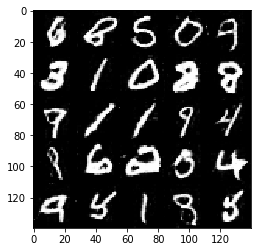

Epoch 4/4... Discriminator Loss: 1.2569... Generator Loss: 0.7525
Epoch 4/4... Discriminator Loss: 1.0001... Generator Loss: 1.0300
Epoch 4/4... Discriminator Loss: 0.9995... Generator Loss: 1.4412
Epoch 4/4... Discriminator Loss: 1.2262... Generator Loss: 1.3186
Epoch 4/4... Discriminator Loss: 1.0532... Generator Loss: 1.4338
Epoch 4/4... Discriminator Loss: 1.1259... Generator Loss: 1.3237
Epoch 4/4... Discriminator Loss: 1.0391... Generator Loss: 1.2374
Epoch 4/4... Discriminator Loss: 1.1219... Generator Loss: 1.2886
Epoch 4/4... Discriminator Loss: 1.1389... Generator Loss: 0.9583
Epoch 4/4... Discriminator Loss: 1.1239... Generator Loss: 1.0551
Epoch 4/4... Discriminator Loss: 1.0971... Generator Loss: 1.1361
Epoch 4/4... Discriminator Loss: 1.1570... Generator Loss: 2.3219
Epoch 4/4... Discriminator Loss: 1.0388... Generator Loss: 0.9684
Epoch 4/4... Discriminator Loss: 0.9773... Generator Loss: 1.4400
Epoch 4/4... Discriminator Loss: 1.0959... Generator Loss: 1.0932


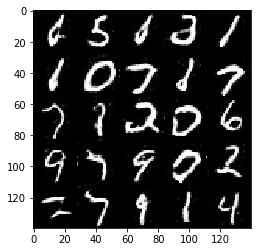

Epoch 4/4... Discriminator Loss: 1.0576... Generator Loss: 1.4374
Epoch 4/4... Discriminator Loss: 1.4103... Generator Loss: 1.9971
Epoch 4/4... Discriminator Loss: 1.2927... Generator Loss: 0.8561
Epoch 4/4... Discriminator Loss: 1.0963... Generator Loss: 1.2325
Epoch 4/4... Discriminator Loss: 1.0513... Generator Loss: 1.9146
Epoch 4/4... Discriminator Loss: 1.0739... Generator Loss: 0.8842
Epoch 4/4... Discriminator Loss: 1.0814... Generator Loss: 1.1783
Epoch 4/4... Discriminator Loss: 1.1881... Generator Loss: 1.2523
Epoch 4/4... Discriminator Loss: 1.1963... Generator Loss: 1.3457
Epoch 4/4... Discriminator Loss: 1.1986... Generator Loss: 1.0531
Epoch 4/4... Discriminator Loss: 1.0427... Generator Loss: 0.8720
Epoch 4/4... Discriminator Loss: 1.2385... Generator Loss: 0.9885
Epoch 4/4... Discriminator Loss: 1.4698... Generator Loss: 0.5166
Epoch 4/4... Discriminator Loss: 1.2179... Generator Loss: 0.9503
Epoch 4/4... Discriminator Loss: 1.1125... Generator Loss: 1.9168


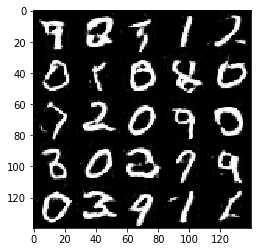

Epoch 4/4... Discriminator Loss: 0.9871... Generator Loss: 1.3804
Epoch 4/4... Discriminator Loss: 1.1341... Generator Loss: 1.3865
Epoch 4/4... Discriminator Loss: 1.1802... Generator Loss: 1.8352
Epoch 4/4... Discriminator Loss: 1.1456... Generator Loss: 0.9675
Epoch 4/4... Discriminator Loss: 1.1428... Generator Loss: 1.4804
Epoch 4/4... Discriminator Loss: 1.1276... Generator Loss: 1.7975
Epoch 4/4... Discriminator Loss: 1.0936... Generator Loss: 1.4019
Epoch 4/4... Discriminator Loss: 1.0358... Generator Loss: 1.1833
Epoch 4/4... Discriminator Loss: 1.0104... Generator Loss: 1.8263
Epoch 4/4... Discriminator Loss: 1.1231... Generator Loss: 1.0291
Epoch 4/4... Discriminator Loss: 1.0753... Generator Loss: 2.0636
Epoch 4/4... Discriminator Loss: 1.7542... Generator Loss: 0.6324
Epoch 4/4... Discriminator Loss: 1.1486... Generator Loss: 0.9363
Epoch 4/4... Discriminator Loss: 1.1339... Generator Loss: 1.4661
Epoch 4/4... Discriminator Loss: 1.1064... Generator Loss: 0.9297


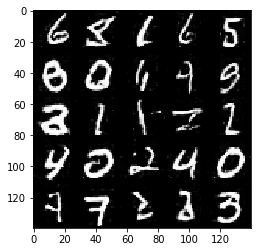

Epoch 4/4... Discriminator Loss: 1.2666... Generator Loss: 0.7907
Epoch 4/4... Discriminator Loss: 1.3225... Generator Loss: 1.0549
Epoch 4/4... Discriminator Loss: 1.1358... Generator Loss: 1.2648
Epoch 4/4... Discriminator Loss: 1.1851... Generator Loss: 1.2704
Epoch 4/4... Discriminator Loss: 1.0722... Generator Loss: 1.4534
Epoch 4/4... Discriminator Loss: 1.0734... Generator Loss: 1.4779
Epoch 4/4... Discriminator Loss: 1.0105... Generator Loss: 1.3763
Epoch 4/4... Discriminator Loss: 1.1482... Generator Loss: 1.3376
Epoch 4/4... Discriminator Loss: 1.0777... Generator Loss: 1.3323
Epoch 4/4... Discriminator Loss: 1.0246... Generator Loss: 1.3232
Epoch 4/4... Discriminator Loss: 1.0460... Generator Loss: 1.4604
Epoch 4/4... Discriminator Loss: 1.1689... Generator Loss: 1.0075
Epoch 4/4... Discriminator Loss: 1.4177... Generator Loss: 2.2275
Epoch 4/4... Discriminator Loss: 1.3774... Generator Loss: 0.8228
Epoch 4/4... Discriminator Loss: 1.1291... Generator Loss: 1.5643


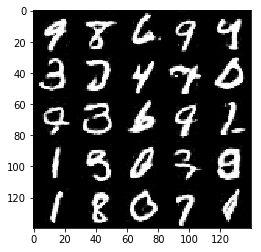

Epoch 4/4... Discriminator Loss: 1.0540... Generator Loss: 1.4794
Epoch 4/4... Discriminator Loss: 1.1649... Generator Loss: 1.0443
Epoch 4/4... Discriminator Loss: 1.0561... Generator Loss: 1.4855
Epoch 4/4... Discriminator Loss: 1.3915... Generator Loss: 0.7217
Epoch 4/4... Discriminator Loss: 1.1381... Generator Loss: 1.4212
Epoch 4/4... Discriminator Loss: 1.1014... Generator Loss: 1.3633
Epoch 4/4... Discriminator Loss: 1.0185... Generator Loss: 1.1244
Epoch 4/4... Discriminator Loss: 1.1123... Generator Loss: 1.0884
Epoch 4/4... Discriminator Loss: 1.1727... Generator Loss: 1.7810
Epoch 4/4... Discriminator Loss: 1.0975... Generator Loss: 0.9091
Epoch 4/4... Discriminator Loss: 1.1159... Generator Loss: 1.5111
Epoch 4/4... Discriminator Loss: 1.0180... Generator Loss: 1.1316
Epoch 4/4... Discriminator Loss: 1.0428... Generator Loss: 1.0838
Epoch 4/4... Discriminator Loss: 1.2282... Generator Loss: 0.8806
Epoch 4/4... Discriminator Loss: 1.0328... Generator Loss: 1.6214


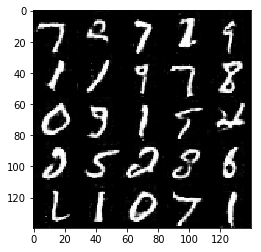

In [17]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 2.9570
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 1.3614
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 2.4772
Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 1.8523
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 2.3075
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 2.1842
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 2.3583
Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 3.1231
Epoch 1/1... Discriminator Loss: 0.9160... Generator Loss: 2.8423
Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 2.0171
Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 1.7216
Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 2.2517
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 2.1617
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 4.1667
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 2.4075


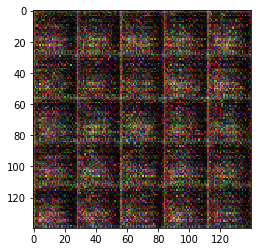

Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 3.8119
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 1.6039
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 4.8649
Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 2.0333
Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 3.4855
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 1.7735
Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 2.4067
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 1.7243
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 2.2621
Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 2.6505
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 1.7783
Epoch 1/1... Discriminator Loss: 0.9281... Generator Loss: 2.5728
Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 3.1981
Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 3.3504
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 2.5630


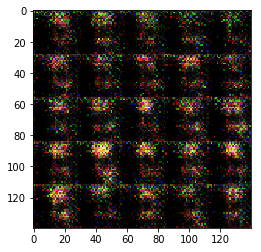

Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 6.1347
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 3.1633
Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 1.4326
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 2.5718
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 1.8693
Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 2.1221
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 7.5795
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 2.6843
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 2.0416
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 1.9858
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 3.0011
Epoch 1/1... Discriminator Loss: 1.0384... Generator Loss: 2.2625
Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 1.9939
Epoch 1/1... Discriminator Loss: 0.8608... Generator Loss: 2.4117
Epoch 1/1... Discriminator Loss: 0.8467... Generator Loss: 2.2717


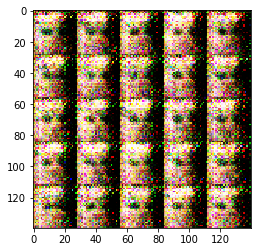

Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 3.2329
Epoch 1/1... Discriminator Loss: 0.9439... Generator Loss: 1.6463
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 2.7781
Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 2.8287
Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 2.0890
Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 1.7890
Epoch 1/1... Discriminator Loss: 0.8738... Generator Loss: 2.2653
Epoch 1/1... Discriminator Loss: 1.0391... Generator Loss: 2.2378
Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 2.9132
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 2.2061
Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 1.6637
Epoch 1/1... Discriminator Loss: 0.9204... Generator Loss: 1.8006
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 2.3851
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 1.7322
Epoch 1/1... Discriminator Loss: 0.9254... Generator Loss: 2.4476


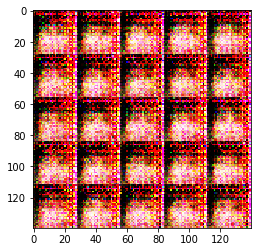

Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 3.0088
Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 2.2123
Epoch 1/1... Discriminator Loss: 0.9305... Generator Loss: 1.7229
Epoch 1/1... Discriminator Loss: 0.8363... Generator Loss: 1.3923
Epoch 1/1... Discriminator Loss: 0.9229... Generator Loss: 2.6692
Epoch 1/1... Discriminator Loss: 0.9100... Generator Loss: 3.2837
Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 2.0056
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 2.1816
Epoch 1/1... Discriminator Loss: 0.9795... Generator Loss: 2.1954
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 1.1519
Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 2.1840
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 1.3982
Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 1.6453
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 3.0172


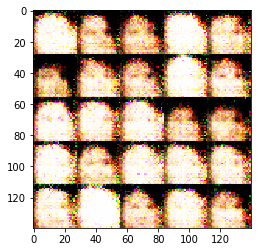

Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 1.1316
Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 3.1271
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 1.7800
Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 2.9115
Epoch 1/1... Discriminator Loss: 0.8817... Generator Loss: 2.4788
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 3.2154
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 2.1550
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 1.7893
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 2.0925
Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 2.1785
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 2.0690
Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 2.2106
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 1.2495
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 1.7377
Epoch 1/1... Discriminator Loss: 0.9410... Generator Loss: 2.0489


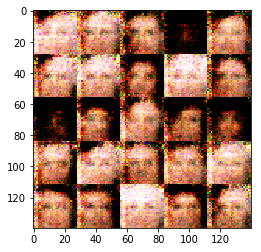

Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 1.7091
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 1.5910
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 2.0791
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 2.4991
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 1.6518
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 1.5996
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 2.4741
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 2.7157
Epoch 1/1... Discriminator Loss: 0.9225... Generator Loss: 2.2689
Epoch 1/1... Discriminator Loss: 0.9371... Generator Loss: 1.5122
Epoch 1/1... Discriminator Loss: 0.8906... Generator Loss: 2.2749
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 1.4106
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 2.2967
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 1.2593


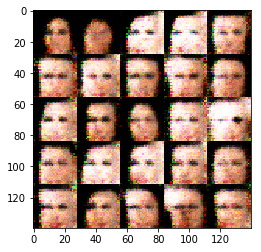

Epoch 1/1... Discriminator Loss: 0.9658... Generator Loss: 1.3807
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 2.3473
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 0.8887... Generator Loss: 2.3769
Epoch 1/1... Discriminator Loss: 0.9545... Generator Loss: 2.1069
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 1.0572
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 1.6359
Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 2.5560
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 2.7168
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 1.6029
Epoch 1/1... Discriminator Loss: 1.0337... Generator Loss: 1.9568
Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 3.5111
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 2.2440
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 1.2922
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 1.3339


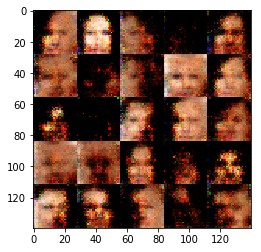

Epoch 1/1... Discriminator Loss: 1.5829... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 1.3254
Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 1.8160
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 1.3418
Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 1.4650
Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 1.9216
Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 1.6568
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 1.9247
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 1.6771
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 0.9824
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 1.9927
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 1.9558
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 1.8811
Epoch 1/1... Discriminator Loss: 0.9106... Generator Loss: 1.7880
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 1.8627


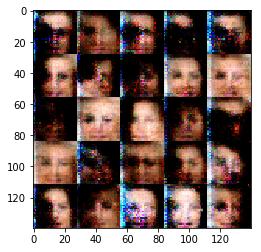

Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 1.9692
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 1.4082
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 1.7535
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 1.3162
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 1.9811
Epoch 1/1... Discriminator Loss: 0.9475... Generator Loss: 2.2100
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 1.4740
Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 1.9216
Epoch 1/1... Discriminator Loss: 0.9722... Generator Loss: 1.6437
Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 1.9805
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 3.1972
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 1.5680
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 1.2242
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 1.1037
Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 1.4491


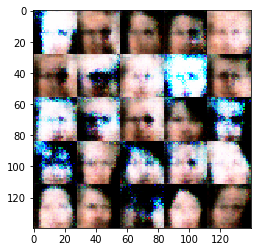

Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 1.3760
Epoch 1/1... Discriminator Loss: 0.9672... Generator Loss: 1.9950
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 1.6785
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 2.1613
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 1.4866
Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 1.6904
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 2.1057
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 1.6099
Epoch 1/1... Discriminator Loss: 0.9801... Generator Loss: 1.3552
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 1.2811
Epoch 1/1... Discriminator Loss: 0.9737... Generator Loss: 1.8288
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 1.9728
Epoch 1/1... Discriminator Loss: 0.9856... Generator Loss: 1.7458
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 1.3406
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 1.6554


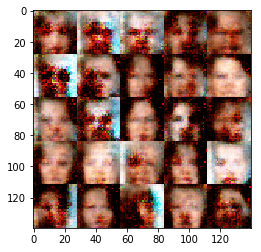

Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 1.4561
Epoch 1/1... Discriminator Loss: 1.0312... Generator Loss: 1.9103
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 2.4248
Epoch 1/1... Discriminator Loss: 0.9784... Generator Loss: 1.1238
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 2.7140
Epoch 1/1... Discriminator Loss: 0.9070... Generator Loss: 1.9116
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 2.0641
Epoch 1/1... Discriminator Loss: 1.0139... Generator Loss: 1.8007
Epoch 1/1... Discriminator Loss: 0.9527... Generator Loss: 1.4724
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 1.8179
Epoch 1/1... Discriminator Loss: 1.0408... Generator Loss: 1.2382
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 1.7684
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 2.6884
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 1.7650
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 1.5160


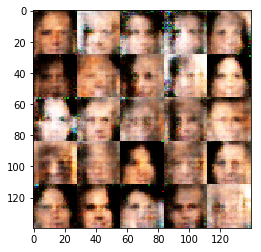

Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 1.5112
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 1.5767
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 1.7742
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 1.6546
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 1.9653
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 1.2759
Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 1.9145
Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 2.0290
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 1.8253
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 3.2346
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 1.7174
Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 2.8717
Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 1.8866
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 2.8156
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 2.5921


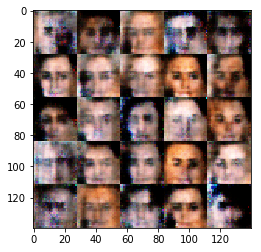

Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 1.2297
Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 1.4052
Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 1.5232
Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 1.6397
Epoch 1/1... Discriminator Loss: 0.9655... Generator Loss: 1.9919
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 1.2959
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 1.3379
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 2.4327
Epoch 1/1... Discriminator Loss: 1.5899... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 1.4220
Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 1.8693
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 1.2140
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 1.7376
Epoch 1/1... Discriminator Loss: 1.0185... Generator Loss: 2.4159
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 1.2133


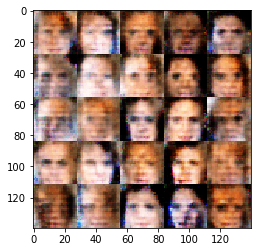

Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 1.1712
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 1.4152
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 2.6136
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 1.6771
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 1.2212
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 1.9481
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 1.6091
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 1.1555
Epoch 1/1... Discriminator Loss: 1.1316... Generator Loss: 1.2396
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 1.1668
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 1.5711
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 2.5002
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 1.4421
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.9860
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 1.2984


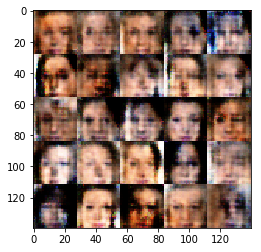

Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 1.2839
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 1.1887
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 1.0432
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 1.6726
Epoch 1/1... Discriminator Loss: 0.9916... Generator Loss: 1.6585
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 1.5691
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 0.9745
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 1.0910
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 1.1793
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 1.4256
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 1.2027
Epoch 1/1... Discriminator Loss: 1.1022... Generator Loss: 1.3219
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.9661
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 1.4836
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 2.3353


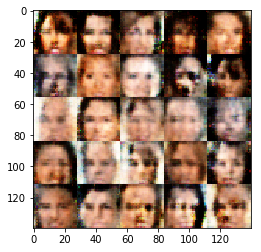

Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 1.4842
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 1.4109
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 0.9678
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 1.0583
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 1.0269
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 1.8261
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 1.5563
Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 1.0548
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 1.6675
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 1.0740
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 1.1652
Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 1.4843
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 1.4633
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 1.5371


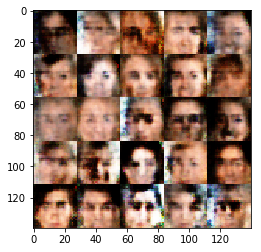

Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 1.1609
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 1.2650
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 1.8611
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 1.6713
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 1.0914
Epoch 1/1... Discriminator Loss: 0.9835... Generator Loss: 1.0381
Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 2.0788
Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 2.2910
Epoch 1/1... Discriminator Loss: 0.9752... Generator Loss: 1.3821
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 1.2243
Epoch 1/1... Discriminator Loss: 0.9627... Generator Loss: 1.6174
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 1.0229
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 1.3359
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 1.7396


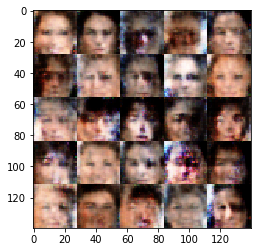

Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 1.0763
Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 1.8117
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 1.2704
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 1.1871
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.9308
Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 1.7872
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 1.9329
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 1.2152
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 1.4312
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 1.4730
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 1.6841
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 1.2263
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 1.4514
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 1.0252


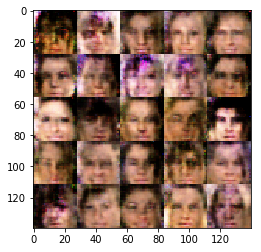

Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 1.4720
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 1.9646
Epoch 1/1... Discriminator Loss: 1.5424... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.9832
Epoch 1/1... Discriminator Loss: 1.0719... Generator Loss: 0.9907
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 1.2482
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 0.9997
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 1.0573
Epoch 1/1... Discriminator Loss: 1.0117... Generator Loss: 1.5726
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 1.4869
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 1.2828
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 1.1446
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 1.2441
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 2.0827


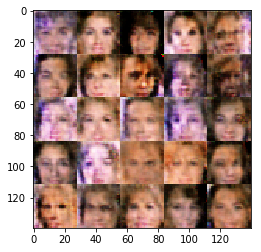

Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 1.2547
Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 1.7308
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 1.3349
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 1.5597
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 1.7251
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 1.0493
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.9374
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 1.2283
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 1.1977
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 1.2463
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 2.1076
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 1.3522
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 1.1426


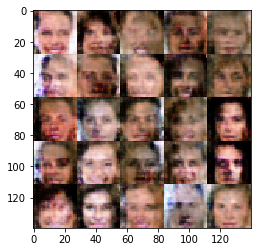

Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.9642
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 1.1910
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 1.4845
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 1.2134
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 1.5532
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 1.1712
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 1.4611
Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 1.0400
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 1.3505
Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 1.1622
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 1.2124
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 1.1175
Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 1.3736


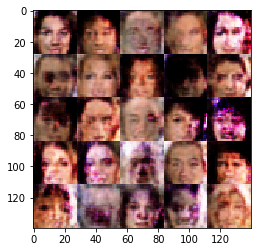

Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 1.7641
Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 1.2931
Epoch 1/1... Discriminator Loss: 1.5944... Generator Loss: 1.6639
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 1.3065
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 1.4942
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 1.7050
Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 1.7374
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 0.9330
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 1.3348
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 1.2462
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 1.3891
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.9914


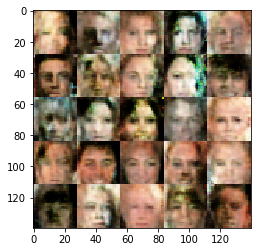

Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 1.7837
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 2.1004
Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 0.9445
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 1.4759
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 1.0053
Epoch 1/1... Discriminator Loss: 1.0138... Generator Loss: 1.4809
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 1.2966
Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 1.1003
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 1.0124
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 1.2943
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 1.0385
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 1.3762
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.9000


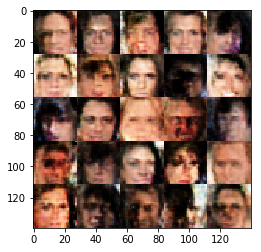

Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 1.2158
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 1.2621
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 1.3523
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.9271
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 1.1129
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 1.5056
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 1.6367
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 1.3259
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 1.1100
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.9524
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 1.3395
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 1.1095
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 1.0909


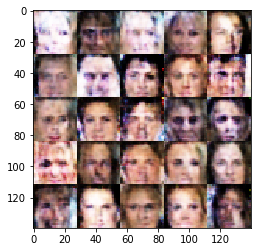

Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 1.3195
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 1.0242
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.9584
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 1.1997
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 1.9404
Epoch 1/1... Discriminator Loss: 1.0806... Generator Loss: 1.2693
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 1.0673
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 1.6508
Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 1.3010
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 1.0650
Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 1.5112
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 1.4872


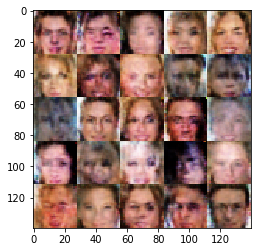

Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 1.1602
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 1.2825
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 1.3963
Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 1.1536
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 1.5817
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 1.1906
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 1.1435
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 1.3357
Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 1.0802
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 1.5760
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 1.3959
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 1.1391
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 1.0966
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 0.8186


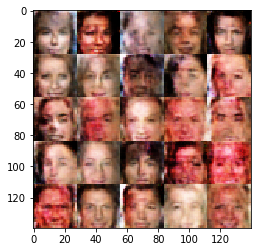

Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 1.1152
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.9826
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 1.1778
Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 1.4671
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 1.5857
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 1.5565
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 1.7400
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 1.9087
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 1.3627
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 1.0273


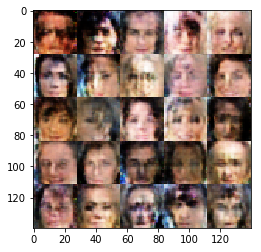

Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 1.1259
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 1.3826
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 1.6854
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 1.2150
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 1.6773
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 1.6246
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 1.9418
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 0.9480
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 1.4422
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 1.5317
Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 1.6798
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 1.2450
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 0.8914


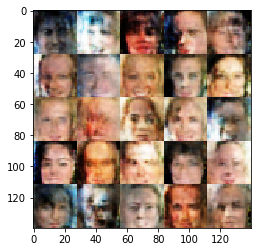

Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 1.2382
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 1.0911
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 0.9574
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 1.7028
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 1.2489
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.9589
Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 1.2208
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 1.2179
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.9958
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 1.2917
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 1.2276
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 1.1946
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 1.3282


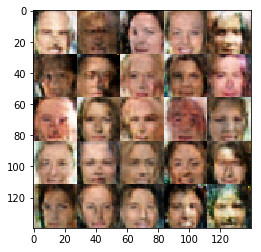

Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 1.3972
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 1.1346
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 1.0636
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 1.1417
Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 1.3435
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 1.2169
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 1.4057
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 1.4492
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 1.1172
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 1.2481
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 1.1356
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 1.0206


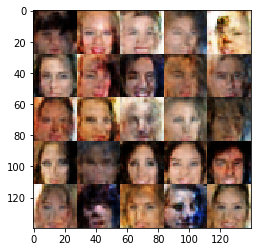

Epoch 1/1... Discriminator Loss: 1.1208... Generator Loss: 1.1475
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 1.3208
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 2.2099
Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 1.1400
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 1.2067
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 1.1118
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 1.0694
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.9119
Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 1.1508
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 1.3668


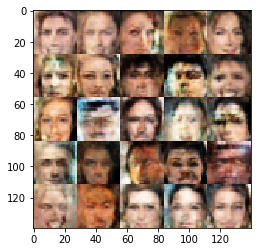

Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 1.1476
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 2.0779
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 1.1849
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 1.4207
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 1.3022
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 1.0611
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 1.1339
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 1.0063
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 1.2347
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 1.1803
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 1.3566


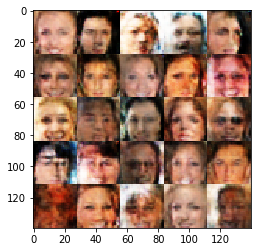

Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 0.9809
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 1.1424
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.1027... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 1.1272
Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 1.0972
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 1.1422
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 1.0646
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 1.4757
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 1.0635
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.8937


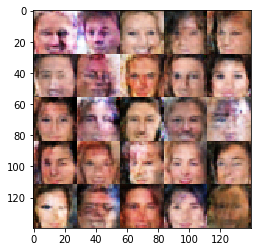

Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 1.2028
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 1.2116
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 1.0789
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 1.3565
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 1.2689
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 1.2040
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 1.2953
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.9400
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 1.1388
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 1.7740
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 1.0164
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.9606
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 0.8777


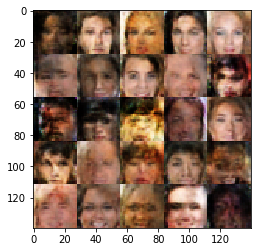

Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.1249... Generator Loss: 1.0692
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 1.0207
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 1.3621
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 1.1950
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 0.9670
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 1.0885
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 1.0676
Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.9418
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 1.0481
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.9061
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 1.4904


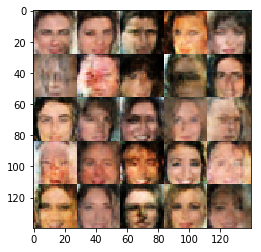

Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 1.2930
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 1.3659
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 1.5799
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 1.1985
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 1.2901
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 1.0533
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 1.2668
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 1.3463
Epoch 1/1... Discriminator Loss: 1.5512... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 0.9881
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 1.2318
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 1.0977
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 1.0713


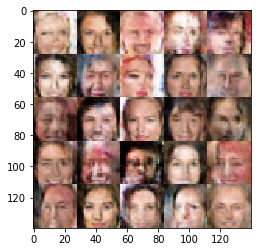

Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 1.2288
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 1.1309
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 1.0506
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 1.9805
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 1.1395
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.9163
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 1.0291
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.9934
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 1.1992
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 1.0307
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 1.1775
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 1.0772
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 1.2847


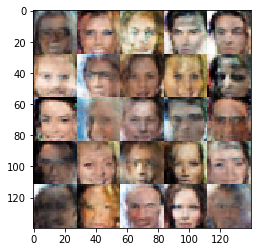

Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 1.2099
Epoch 1/1... Discriminator Loss: 1.4968... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 1.0995
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 1.1201
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 1.0672
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 1.0707
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 1.0249
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 1.0281
Epoch 1/1... Discriminator Loss: 1.0255... Generator Loss: 1.1218
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 1.3124
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 1.3417
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 1.3309


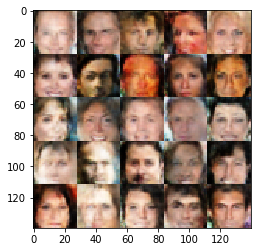

Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 1.2126
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 1.3292
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.9376
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 1.0217
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 2.0171
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 1.0333
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 1.1942
Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 1.4657
Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 1.1227
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 1.0999
Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 1.3323
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 1.2160
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 1.1787


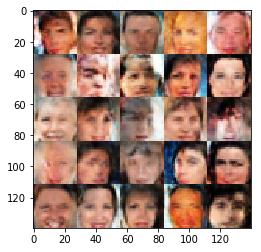

Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 1.2827
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.9578
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 1.0728
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 1.1385
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 1.3157
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 1.0665
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 0.9863
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 1.5962
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 1.5681
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 1.1159
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 1.6229


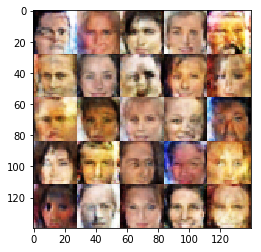

Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 1.0681
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 1.4304
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 1.2108
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 1.2582
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 1.3973
Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 1.4952
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.9593
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.0443... Generator Loss: 1.3035
Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 0.9733
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.8279


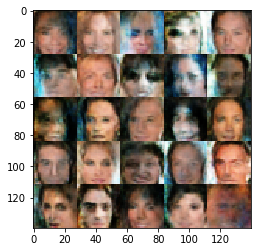

Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 1.0107
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.9575


In [19]:
batch_size = 32
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.